# P3

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import networkx as nx

# Part 1

## 1.1] Replicate Table 3 for the Reddit data

### 1.1.1]Load the Reddit data and do some basic analysis

**Load the data**

In [3]:
data_body = pd.read_csv('soc-redditHyperlinks-body.tsv', sep = '\t')
data_title = pd.read_csv('soc-redditHyperlinks-title.tsv', sep = '\t')
data_body.head(2)

,SOURCE_SUBREDDIT,TARGET_SUBREDDIT,POST_ID,TIMESTAMP,LINK_SENTIMENT,PROPERTIES
0,leagueoflegends,teamredditteams,1u4nrps,2013-12-31 16:39:58,1,"345.0,298.0,0.75652173913,0.0173913043478,0.08..."
1,theredlion,soccer,1u4qkd,2013-12-31 18:18:37,-1,"101.0,98.0,0.742574257426,0.019801980198,0.049..."


We rename the sign column, to have consistency with datasets like wikipedia, slashdot, epinions

In [5]:
data_body = data_body.rename(columns = {'LINK_SENTIMENT' : 'Sign'})
data_title = data_title.rename(columns = {'LINK_SENTIMENT' : 'Sign'})
data_body.head(10)

,SOURCE_SUBREDDIT,TARGET_SUBREDDIT,POST_ID,TIMESTAMP,Sign,PROPERTIES
0,leagueoflegends,teamredditteams,1u4nrps,2013-12-31 16:39:58,1,"345.0,298.0,0.75652173913,0.0173913043478,0.08..."
1,theredlion,soccer,1u4qkd,2013-12-31 18:18:37,-1,"101.0,98.0,0.742574257426,0.019801980198,0.049..."
2,inlandempire,bikela,1u4qlzs,2014-01-01 14:54:35,1,"85.0,85.0,0.752941176471,0.0235294117647,0.082..."
3,nfl,cfb,1u4sjvs,2013-12-31 17:37:55,1,"1124.0,949.0,0.772241992883,0.0017793594306,0...."
4,playmygame,gamedev,1u4w5ss,2014-01-01 02:51:13,1,"715.0,622.0,0.777622377622,0.00699300699301,0...."
5,dogemarket,dogecoin,1u4w7bs,2013-12-31 18:35:44,1,"1328.0,1110.0,0.768825301205,0.0143072289157,0..."
6,locationbot,legaladvice,1u4wfes,2014-01-07 20:17:41,1,"184.0,172.0,0.744565217391,0.0326086956522,0.0..."
7,indiefied,aww,1u50pos,2014-03-03 17:00:35,1,"295.0,256.0,0.749152542373,0.0203389830508,0.0..."
8,posthardcore,bestof2013,1u5ccus,2013-12-31 23:16:20,1,"3927.0,3488.0,0.719887955182,0.0229182582124,0..."
9,posthardcore,corejerk,1u5ccus,2013-12-31 23:16:20,1,"3927.0,3488.0,0.719887955182,0.0229182582124,0..."


**Create the dataframe containing body + title links**

In [6]:
data_total = pd.concat([data_body,data_title], ignore_index = True)
data_total.head()

,SOURCE_SUBREDDIT,TARGET_SUBREDDIT,POST_ID,TIMESTAMP,Sign,PROPERTIES
0,leagueoflegends,teamredditteams,1u4nrps,2013-12-31 16:39:58,1,"345.0,298.0,0.75652173913,0.0173913043478,0.08..."
1,theredlion,soccer,1u4qkd,2013-12-31 18:18:37,-1,"101.0,98.0,0.742574257426,0.019801980198,0.049..."
2,inlandempire,bikela,1u4qlzs,2014-01-01 14:54:35,1,"85.0,85.0,0.752941176471,0.0235294117647,0.082..."
3,nfl,cfb,1u4sjvs,2013-12-31 17:37:55,1,"1124.0,949.0,0.772241992883,0.0017793594306,0...."
4,playmygame,gamedev,1u4w5ss,2014-01-01 02:51:13,1,"715.0,622.0,0.777622377622,0.00699300699301,0...."


**Convert the names into ids**

In [7]:
from gensim.corpora import Dictionary

unique_subreddits = [[element] for element in list(pd.concat([data_total['SOURCE_SUBREDDIT'], data_total['TARGET_SUBREDDIT']]).sort_values().unique())]
dct = Dictionary(unique_subreddits)

data_total['FromNodeId'] = dct.doc2idx(data_total['SOURCE_SUBREDDIT'].values)
data_total['ToNodeId'] = dct.doc2idx(data_total['TARGET_SUBREDDIT'].values)

In [22]:
test = data_body[data_body['SOURCE_SUBREDDIT'] == 'leagueoflegends']
test[test['TARGET_SUBREDDIT'] == 'leagueoflegendsmeta']

,SOURCE_SUBREDDIT,TARGET_SUBREDDIT,POST_ID,TIMESTAMP,Sign,PROPERTIES
311,leagueoflegends,leagueoflegendsmeta,1ue5u4s,2014-01-04 07:15:08,1,"705.0,604.0,0.756028368794,0.00567375886525,0...."
27785,leagueoflegends,leagueoflegendsmeta,28luias,2014-06-19 20:03:26,1,"1763.0,1431.0,0.667612024957,0.0328984685196,0..."
78113,leagueoflegends,leagueoflegendsmeta,2ygs2ns,2015-03-09 12:18:40,1,"1963.0,1643.0,0.792154865003,0.00254712175242,..."
108915,leagueoflegends,leagueoflegendsmeta,3d3lkls,2015-07-13 00:32:14,1,"4002.0,3336.0,0.755872063968,0.0114942528736,0..."
136923,leagueoflegends,leagueoflegendsmeta,3qzyi1s,2015-10-31 20:19:30,1,"1809.0,1512.0,0.782752902156,0.00110558319514,..."


In [21]:

np.count_nonzero(data_body[data_body['SOURCE_SUBREDDIT'] == 'leagueoflegends']['TARGET_SUBREDDIT'].values == 'leagueoflegendsmeta')

5

**Count the number of nodes and edges**

In [7]:
table = pd.DataFrame(columns = ['body', 'title', 'total'], index = ['Nodes', 'Edges', '+ edges', '- edges'])

nb_edges_body = data_body.shape[0]
nb_nodes_body = np.unique(np.concatenate((data_body['SOURCE_SUBREDDIT'].values , data_body['TARGET_SUBREDDIT'].values))).shape[0]

nb_edges_title = data_title.shape[0]
nb_nodes_title = np.unique(np.concatenate((data_title['SOURCE_SUBREDDIT'].values , data_title['TARGET_SUBREDDIT'].values))).shape[0]

nb_edges_total = data_total.shape[0]
nb_nodes_total = np.unique(np.concatenate((data_total['SOURCE_SUBREDDIT'].values , data_total['TARGET_SUBREDDIT'].values))).shape[0]


table.loc['Nodes'] = [nb_nodes_body, nb_nodes_title, nb_nodes_total]
table.loc['Edges'] = [nb_edges_body, nb_edges_title, nb_edges_total]

table.head()

,body,title,total
Nodes,35776,54075,67180
Edges,286561,571927,858488
+ edges,NaN,NaN,NaN
- edges,NaN,NaN,NaN


**Count the proportion of positives and negative edges**

To apply this to several datasets, we create a function

In [8]:
#Number of positive (negative) edges :
#We first filter the data by keeping only +1 (or -1) values and then we find the number of lines (edges) that this filtering gives
nb_pos_edges_body = data_body[data_body['Sign']==1].shape[0] 
nb_neg_edges_body = data_body[data_body['Sign']==-1].shape[0]

nb_pos_edges_title = data_title[data_title['Sign']==1].shape[0] 
nb_neg_edges_title= data_title[data_title['Sign']==-1].shape[0]

nb_pos_edges_total = data_total[data_total['Sign']==1].shape[0] 
nb_neg_edges_total = data_total[data_total['Sign']==-1].shape[0]

#Proportion of positive/negative edges:
#We divide the number of positive (or negative) edges previouly found and divide it by the total number of edges
#We use the table1 to find the total number of edges as we already filled these informations
perc_pos_body = nb_pos_edges_body / table.loc['Edges']['body']
perc_neg_body = nb_neg_edges_body / table.loc['Edges']['body']

perc_pos_title = nb_pos_edges_title / table.loc['Edges']['title']
perc_neg_title = nb_neg_edges_title / table.loc['Edges']['title']

perc_pos_total = nb_pos_edges_total / table.loc['Edges']['total']
perc_neg_total = nb_neg_edges_total / table.loc['Edges']['total']

In [9]:
#We must indicate a percentage format : we use the {:.1%} format to have a percentage with only one decimal, as in the paper 
table.loc['+ edges'] = ['{:.1%}'.format(perc_pos_body), '{:.1%}'.format(perc_pos_title), '{:.1%}'.format(perc_pos_total)]
table.loc['- edges'] = ['{:.1%}'.format(perc_neg_body), '{:.1%}'.format(perc_neg_title), '{:.1%}'.format(perc_neg_total)]

table.head()

,body,title,total
Nodes,35776,54075,67180
Edges,286561,571927,858488
+ edges,92.6%,89.3%,90.4%
- edges,7.4%,10.7%,9.6%


In the following, we take the total dataframe.

### 1.1.2] Replicate table 3

**Create the graph with networkx**

In [35]:
from table3 import create_table3

table3_reddit = create_table3(data_total, data_type = 'reddit')

In [36]:
table3_reddit.head()

,Triad Ti,|Ti|,p(Ti),p0(Ti),s(Ti)
0,T3 +++,1644323,0.863557,0.895420,-143.680338
1,T1 +--,41431,0.021759,0.009851,166.372390
2,T2 ++-,209148,0.109839,0.093704,76.401376
3,T1 ---,9225,0.004845,0.001024,164.806020


## 1.2] Study the impact of the proportion of positive edge on the table 3

By studying the results of this change on table 3, we can study how the proportion of positive edges impact the balance theory.

### 1.2.1] Remove some lines with positive link to have a dataset with 70% of positive edges

In [41]:
data_remove = pd.concat((data_total[data_total['Sign']==-1], data_total[data_total['Sign']==1].sample(frac = 1).head(192000)))

nb_edges_remove = data_remove.shape[0]
nb_nodes_remove = np.unique(np.concatenate((data_remove['SOURCE_SUBREDDIT'].values , data_remove['TARGET_SUBREDDIT'].values))).shape[0]

nb_pos_edges_remove = data_remove[data_remove['Sign']==1].shape[0] 
nb_neg_edges_remove = data_remove[data_remove['Sign']==-1].shape[0]

perc_pos_remove = nb_pos_edges_remove / nb_edges_remove
perc_neg_remove = nb_neg_edges_remove / nb_edges_remove

table['remove_70'] = [nb_nodes_remove, nb_edges_remove, '{:.1%}'.format(perc_pos_remove), '{:.1%}'.format(perc_neg_remove)]
table.head()

,body,title,total,remove
Nodes,35776,54075,67180,40375
Edges,286561,571927,858488,274152
+ edges,92.6%,89.3%,90.4%,70.0%
- edges,7.4%,10.7%,9.6%,30.0%


**Create table 3 for this dataset, after removal of some positive edges**

In [43]:
from table3 import create_table3

table3_reddit = create_table3(data_remove, data_type = 'reddit')

In [44]:
table3_reddit.head()

,Triad Ti,|Ti|,p(Ti),p0(Ti),s(Ti)
0,T3 +++,323566,0.823078,0.591102,295.845970
1,T1 +--,10727,0.027287,0.108622,-163.888680
2,T2 ++-,56703,0.144240,0.253402,-157.356572
3,T1 ---,2121,0.005395,0.046874,-123.039876


### 1.2.2] Remove some lines with positive link to have a dataset with 50% of positive edges

In [50]:
data_remove = pd.concat((data_total[data_total['Sign']==-1], data_total[data_total['Sign']==1].sample(frac = 1).head(82000)))

nb_edges_remove = data_remove.shape[0]
nb_nodes_remove = np.unique(np.concatenate((data_remove['SOURCE_SUBREDDIT'].values , data_remove['TARGET_SUBREDDIT'].values))).shape[0]

nb_pos_edges_remove = data_remove[data_remove['Sign']==1].shape[0] 
nb_neg_edges_remove = data_remove[data_remove['Sign']==-1].shape[0]

perc_pos_remove = nb_pos_edges_remove / nb_edges_remove
perc_neg_remove = nb_neg_edges_remove / nb_edges_remove

table['remove_50'] = [nb_nodes_remove, nb_edges_remove, '{:.1%}'.format(perc_pos_remove), '{:.1%}'.format(perc_neg_remove)]
table.head()

,body,title,total,remove,remove_50
Nodes,35776,54075,67180,40375,31507
Edges,286561,571927,858488,274152,164152
+ edges,92.6%,89.3%,90.4%,70.0%,50.0%
- edges,7.4%,10.7%,9.6%,30.0%,50.0%


In [51]:
table3_reddit = create_table3(data_remove, data_type = 'reddit')
table3_reddit.head()

,Triad Ti,|Ti|,p(Ti),p0(Ti),s(Ti)
0,T3 +++,92894,0.608858,0.589994,14.980611
1,T1 +--,15752,0.103244,0.108608,-6.733679
2,T2 ++-,36952,0.242195,0.254555,-11.082951
3,T1 ---,6973,0.045703,0.046842,-2.105825


## 1.3] Study of reciprocated links

This part consist in replicating table 4 for the reddit data to enforce or refute the conclusion the authors do about reciprocated edges : balance theory is good to predict the sign of the reciprocated link of a positive link, and status explains well the sign of the reciprocated link of a negative link. 

We first replicate the table 4 for the wikipedia dataset to prove that our process is correct, and to ensure the reproducibility of this part of the paper.

### 1.3.1] Reciprocation of table 4 for the wikipedia dataset

**Load the wikipedia data and remove its neutral links**

We use the parsed file we created in P2.

In [93]:
wiki_data = pd.read_csv('wiki_parsed.txt', sep = '\t', header = None) #we load the data
wiki = wiki_data.rename(columns={0: "FromNodeId", 1 : "ToNodeId", 2 : "Sign"}) #renamethe columns
neutral_indx = wiki[wiki.Sign==0].index.values #We filter the dataset to keep neutral links and find the values of the indexes
wiki = wiki.drop(neutral_indx) #We drop these lines

In [95]:
import networkx as nx

G = nx.from_pandas_edgelist(wiki, 'FromNodeId', 'ToNodeId', edge_attr = 'Sign')

In [104]:
L = []
for node in G.nodes():
    neighbors = G[node]
    for neighbor in neighbors:
        if node in G[neighbor]:
            L.append((node, neighbor))

In [105]:
len(L)

201582

**Create a dataframe that contains only reciprocated edges**

Notation : if A links towards B, we name A as the starting node, and B as the target node.<br>
Let A links towards B, a simple description of our strategy  to find if B links to A is to find all edges that have B as a starting node. If A is a part of the target nodes of B, then B links to A. We create a dataframe for which we only include reciprocated edges, we add both the edges from A to B, and from B to A.

The detailed code strategy to find reciprocated edges is : 
- Initialization : create a dataframe that will contain the edges for which we have a reciprocation.
- 1st loop : we loop over all starting nodes, namely we loop over each `from_node`. For each `from_node`, we filter the original dataset to only have edges that have `from_node` as starting node.
- 2nd loop : we loop over each target node of `from_node`. For each of these `to_node`, we filter the dataset to have edges that starts from `to_node`.
- Test assignement : if `from_node` is a part of the target node of `to_node`, then we add the edges. Sometimes there is the same edge several times : we have $A \rightarrow B$ several times. We decide to only have each edge one time : we just include $A \rightarrow B$ one time and $B \rightarrow A$ one time.

In [76]:
#Initialization
wiki_reci = pd.DataFrame()

#1st loop : #for all starting nodes
for from_node in wiki['FromNodeId'].unique(): 
    #filter the dataset to have only the edges that have from_node as a starting node
    from_df = wiki[wiki['FromNodeId'] == from_node]
    
    #2nd loop : for each target node for 'from_node', the starting node 
    for to_node in from_df['ToNodeId'].values : 
        #filter the dataset to have the edges that have as starting node, the target node of 'from_node'
        to_df = wiki[wiki['FromNodeId'] == to_node] 
        
        if from_node in to_df['ToNodeId'].values: #
            #we add both edges
            wiki_reci = pd.concat([wiki_reci, wiki.loc[(wiki['FromNodeId'] ==from_node) & (wiki['ToNodeId']==to_node)].head(1)])
            wiki_reci = pd.concat([wiki_reci, wiki.loc[(wiki['FromNodeId'] == to_node) & (wiki['ToNodeId']==from_node)].head(1)])
            #we need to drop at least one edge from the original data to not add the reciprocation several times
            wiki = wiki.drop(wiki.loc[(wiki['FromNodeId'] ==from_node) & (wiki['ToNodeId']==to_node)].index)
            wiki = wiki.drop(wiki.loc[(wiki['FromNodeId'] ==to_node) & (wiki['ToNodeId']==from_node)].index)
            
wiki_reci.head() #2min30

,FromNodeId,ToNodeId,Sign
33,3,54,1
1157,54,3,1
720,3,28,1
1180,28,3,1
2144,3,178,1


In [ ]:
wiki_reci.shape[0]

We first want to know what part of the original wikipedia reciprocated edges represent. The authors say that about 3-5% of the original dataset's edges are reciprocation of existing links. 

To check this, we divide the number of edges of this dataframe containing reciprocated edges by two time the number of edges in the original dataset (because we counted the link and its reciprocation, while in the paper they only count the reciprocation).

In [39]:
#we compute the proportion
print('propotion of reciprocated edges : {:.2%}'.format(wiki_reci.shape[0]/(2*wiki.shape[0])))

propotion of reciprocated edges : 2.96%


It seems we have a similar result than with the paper. Now we replicate table 4

**Replication of table 4 for the wikipedia dataset**

To do this, we first create the networkx graph associated with this dataframe. Then we replicate table 4. The idea to find the `P(+|+)` and `P(-|+)` is the following : for each node, we find each of its neighbors linked with a positive sign to it, and then we test what is the sign of the reciprocated link, and add a count to the corresponding field.

In [78]:
from table4 import create_table4

table4_wiki = create_table4(wiki_reci, name_data = 'wikipedia')
table4_wiki.head()

,wikipedia,Count,Fraction
0,P(+|+),2542,0.950636
1,P(-|+),132,0.049364
2,P(+|-),206,0.662379
3,P(-|-),105,0.337621


Here is the table 4 from the paper :
>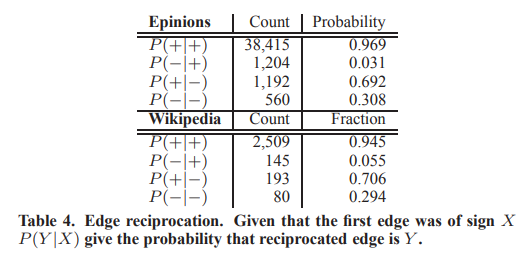

Our results are not the exact same, but are very close to the ones in the paper. We conclude on a good replication power of the paper for this table. We use the same process for the reddit data.

### 1.3.2] Replication of table 4 for the reddit dataset

We basically copy the functions from before, but with the reddit data

**Create a dataframe that contains only reciprocated edges**

We use the exact same code as before, but his time we use the reddit dataset.

In [10]:
reddit = data_total

reddit_reci = pd.DataFrame()
for from_node in reddit['FromNodeId'].unique(): #for all unique nodes
    #filter the dataset to have only the edges that have from_node as a starting node
    from_df = reddit[reddit['FromNodeId'] == from_node]
    for to_node in from_df['ToNodeId'].values : #for all target node of 'from_node'
        to_df = reddit[reddit['FromNodeId'] == to_node]
        if from_node in to_df['ToNodeId'].values:
            #we add both edges
            reddit_reci = pd.concat([reddit_reci, reddit.loc[(reddit['FromNodeId'] ==from_node) & (reddit['ToNodeId']==to_node)].head(1)])
            reddit_reci = pd.concat([reddit_reci, reddit.loc[(reddit['FromNodeId'] == to_node) & (reddit['ToNodeId']==from_node)].head(1)])
            #we need to drop at least one edge from the original data to not add the reciprocation several times
            reddit = reddit.drop(reddit.loc[(reddit['FromNodeId'] ==from_node) & (reddit['ToNodeId']==to_node)].index)
            reddit = reddit.drop(reddit.loc[(reddit['FromNodeId'] ==to_node) & (reddit['ToNodeId']==from_node)].index)
            
reddit_reci.head() 

,SOURCE_SUBREDDIT,TARGET_SUBREDDIT,POST_ID,TIMESTAMP,Sign,PROPERTIES,FromNodeId,ToNodeId
0,leagueoflegends,teamredditteams,1u4nrps,2013-12-31 16:39:58,1,"345.0,298.0,0.75652173913,0.0173913043478,0.08...",32023,57105
6172,teamredditteams,leagueoflegends,1xoxyes,2014-02-11 23:07:12,1,"288.0,252.0,0.774305555556,0.00694444444444,0....",57105,32023
311,leagueoflegends,leagueoflegendsmeta,1ue5u4s,2014-01-04 07:15:08,1,"705.0,604.0,0.756028368794,0.00567375886525,0....",32023,32026
4196,leagueoflegendsmeta,leagueoflegends,1wl2hzs,2014-01-30 12:32:16,1,"1117.0,928.0,0.761862130707,0.000895255147717,...",32026,32023
320,leagueoflegends,iama,1ueax1s,2014-01-04 08:32:51,1,"110.0,110.0,0.763636363636,0.0363636363636,0.0...",32023,27319


This operation took a very long time (hours), so i save it into a csv file to not running it again if needed.

In [21]:
#save it into a csv file
reddit_reci.to_csv('reddit_reciprocation.csv')

In [22]:
#If we saved the csv file, we can load it :
reddit_reci = pd.read_csv('reddit_reciprocation.csv')

In [13]:
#we compute the proportion
print('propotion of reciprocated edges : {:.2%}'.format(reddit_reci.shape[0]/(2*reddit.shape[0])))

propotion of reciprocated edges : 5.38%


The proportion of the original dataset to be reciprocated edges is higher than for the wikipedia dataset.

**Replication of table 4**

In [23]:
from table4 import create_table4

table4_reddit = create_table4(reddit_reci, name_data = 'reddit')
table4_reddit.head()

,reddit,Count,Fraction
0,P(+|+),27002,0.954505
1,P(-|+),1287,0.045495
2,P(+|-),1482,0.878483
3,P(-|-),205,0.121517


The results seems to be consistent with the conclusion authors make : if A-B is positive, we have in 95.4% of cases that B-A is positive as well, which is higher than the 90% os positive links in the data. So balance theory explains well the proportion of $P(+|+)$, as a reciprocation of a positive link should be positive as well. 

Plus, if A-B is negative, B-A is positive in 87.8% of cases. Which is (a bit) lower than the 90% of positive edges. Therefore we say that status theory explains well the high proportion of $P(+|-)$, as if A links negatively to B (A thinks B has a ower status), then B should link positively to A (B thinks A has a higher status). 

**By curiosity, we can see several examples of links that satisfies $P(-|+)$, $P(+|-)$ and $P(-|-)$**

In [28]:
#Examples of links satisfying P(-|+)
from table4 import print_p2

print_p2(reddit_reci, name_data = 'reddit', nb_ex = 10)

Examples of subreddits (A,B) satisfying P(-|+) : A link positive to B, B link negative to A 
example 1 :
A : leagueoflegends
B : gaming

example 2 :
A : leagueoflegends
B : leagueofmemes

example 3 :
A : nfl
B : chibears

example 4 :
A : nfl
B : detroitlions

example 5 :
A : nfl
B : steelers

example 6 :
A : nfl
B : showerthoughts

example 7 :
A : dogemarket
B : dogecoinscamwatch

example 8 :
A : metalcore
B : music

example 9 :
A : suicidewatch
B : needadvice

example 10 :
A : suicidewatch
B : mensrights



In [26]:
#Examples of links satisfying P(+|-)
from table4 import print_p3

print_p3(reddit_reci, name_data = 'reddit', nb_ex = 4)

Examples of subreddits (A,B) satisfying P(+|-) : A link negative to B, B link positive to A 
example 1 :
A : leagueoflegends
B : cringepics

example 2 :
A : leagueoflegends
B : gameofthrones

example 3 :
A : leagueoflegends
B : todayilearned

example 4 :
A : leagueoflegends
B : caitlynmains



In [27]:
#Examples of links satisfying P(-|-)
from table4 import print_p4

print_p4(reddit_reci, name_data = 'reddit', nb_ex = 4)

Examples of subreddits (A,B) satisfying P(-|-) : A link negative to B, B link positive to A 
example 1 :
A : leagueoflegends
B : bestof

example 2 :
A : leagueoflegends
B : dotamasterrace

example 3 :
A : suicidewatch
B : bestof

example 4 :
A : circlebroke
B : shitredditsays

